In [1]:
import pandas as pd 

In [2]:
import os

# PREPROCESS DATA

In [3]:
#Parse raw message into email dictionary
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keyword = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keyword:
                email[key] = val
    return email

In [4]:
#return a dictionary represent emails with body, to and from KEYS
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

In [5]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [6]:
#This function will ignore file that cannot be read as ASCII encode
def readAllFile(path):
    result = []
    for root, dirs, files in os.walk(path):
        for file in files:
            try:
                with open(os.path.join(root, file), "r") as auto:
                    result.append(auto.read())
            except:
                continue
    return result

In [7]:
trainData = readAllFile("maildir")

In [8]:
print(len(trainData))

109280


In [9]:
#Because Jupyter Lab has limit on memory usage, we cannot analyze all data 
#Hence, we limit it down to first 10000 training data 
#On other IDE, we can remove this restraint
email_df = pd.DataFrame(parse_into_emails(trainData[0:10000]))

In [10]:
#Remove empty column data 
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [11]:
email_df.shape

(9469, 3)

In [12]:
email_df.head()

,body,to,from_
0,AmericaIn today's Daily Update you'll find fre...,pallen@enron.com,1.11913372.-2@multexinvestornetwork.com
2,---------------------- Forwarded by Phillip K ...,Richard Burchfield/HOU/ECT@ECT,phillip.allen@enron.com
3,---------------------- Forwarded by Phillip K ...,Richard Burchfield/HOU/ECT@ECT,phillip.allen@enron.com
4,"Dave,Here are the names of the west desk membe...",david.delainey@enron.com,phillip.allen@enron.com
5,"Paula,35 million is finePhillip",paula.harris@enron.com,phillip.allen@enron.com


# Analyze text with TF_IDF

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

In [14]:
import numpy as np

In [15]:
import matplotlib.pyplot as plt 

In [16]:
#Utility function to print features 
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

#get top features in each cluster after fitting
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

#Return a data frame contains the features and the score 
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

In [17]:
stopwords = ENGLISH_STOP_WORDS
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.50, min_df=2)
matrix = vect.fit_transform(email_df.body)

In [18]:
matrix_dense = matrix.todense()
coords = PCA(n_components=2).fit_transform(matrix_dense)

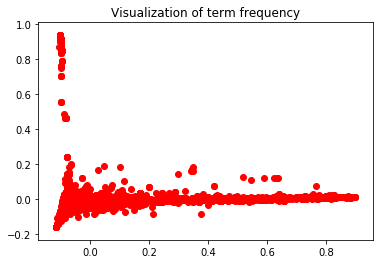

In [41]:
plt.title('Visualization of term frequency')
plt.scatter(coords[:,0], coords[:,1], c='r')
plt.show()

In [19]:
#Explore the feature of the training data
features = vect.get_feature_names()

In [20]:
#Check the top features 
print(top_feats_in_doc(matrix, features, 1, 10))

    features     score
0   position  0.443638
1        tds  0.276986
2    ability  0.192403
3   physical  0.167768
4      scope  0.162317
5  positions  0.158744
6    options  0.144776
7      deals  0.123498
8       grid  0.122657
9    manager  0.122192


It seems like the email was talking mainly about working matter with term such as options, deals, scope. It also mentions about business hierachy with manager, positions

In [21]:
#print the terms appears most frequently of all email
print(top_mean_feats(matrix, features, top_n=10))

   features     score
0     enron  0.053032
1       com  0.041845
2       ect  0.027864
3       hou  0.017756
4   message  0.016679
5  original  0.014459
6   phillip  0.011973
7     image  0.009911
8       gas  0.008953
9     email  0.008577


# Clustering using KMeans

In unsupervise learning, always try to use KMeans first as this is the most straight forward method to do some testing 

In [40]:
#let write a function to display the score most popular terms for each cluster 
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#FF1DCE')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [23]:
clusterNo = 3 
clf = KMeans(n_clusters=clusterNo, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(matrix)

In [24]:
label_colors = ["#FF7F7F", "#66B266", "#6666FF"]
colors = [label_colors[i] for i in labels]

In [25]:
pca = PCA(n_components=2).fit(matrix_dense)
coords = pca.transform(matrix_dense)
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)

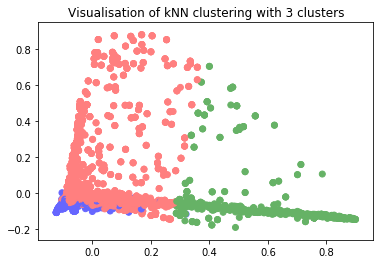

In [26]:
plt.title("Visualisation of kNN clustering with 3 clusters")
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
plt.show()

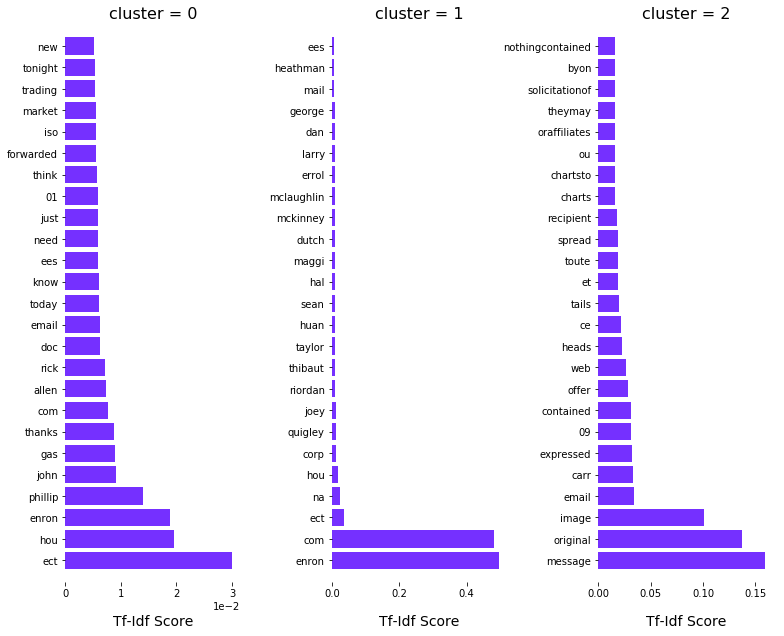

In [27]:
plot_tfidf_classfeats_h(top_feats_per_cluster(matrix, labels, features, 0.1, 25))

From the result, we can see that some random terms appears quite frequently such as hou, etc. Upon checking the text, seems like the hou and etc is just filler information and doesn not has any valueable information
Also, some of the email related words such as:
com (domain), enron (company name) has large occurance as well 
Hence we will add in to the stop words and rerun the analysis

In [30]:
stopwords = ENGLISH_STOP_WORDS.union(["com", "hou", "etc", "enron"])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.50, min_df=2)
matrix = vect.fit_transform(email_df.body)
matrix_dense = matrix.todense()
coords = PCA(n_components=2).fit_transform(matrix_dense)
#Explore the feature of the training data
features = vect.get_feature_names()
#KMEANS
clusterNo = 3 
clf = KMeans(n_clusters=clusterNo, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(matrix)
#extract centroids
pca = PCA(n_components=2).fit(matrix_dense)
coords = pca.transform(matrix_dense)
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)

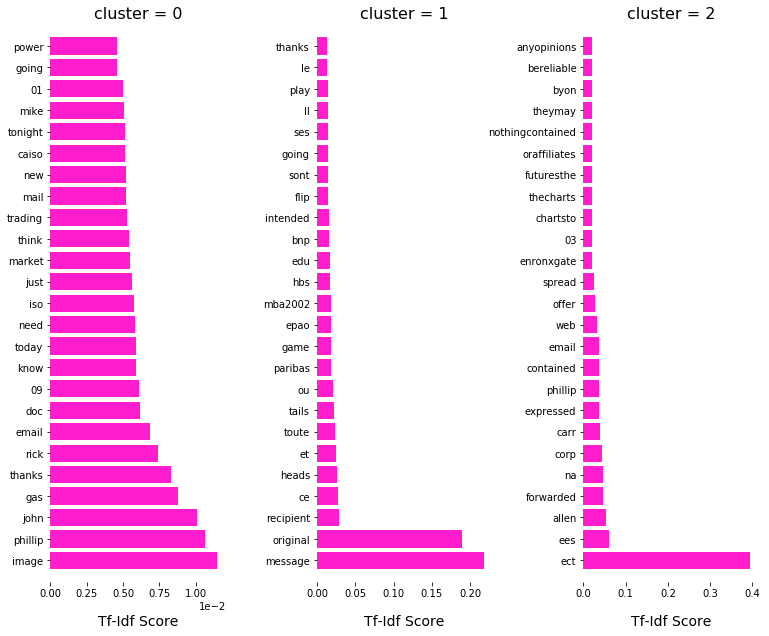

In [41]:
#show data
plot_tfidf_classfeats_h(top_feats_per_cluster(matrix, labels, features, 0.1, 25))

From the result:

-The first cluster seems to has the most information and would reuiqres further analysis.

-The sencond cluster seems to includes random information that is not  very interesting, most of the are domain name like ou, edu, bnp. The highest core amoth them is original and message which are just common word in email 

-The last cluster shows no information at all 